In [5]:
import pandas as pd
import numpy as np
import pickle
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [6]:
def ReLU(Z):
    return np.maximum(Z,0)

In [7]:
def derivative_ReLU(Z):
    return Z > 0

In [8]:
def softmax(Z):
    """Compute softmax values for each sets of scores in x."""
    exp = np.exp(Z - np.max(Z)) #le np.max(Z) evite un overflow en diminuant le contenu de exp
    return exp / exp.sum(axis=0)

In [257]:
def init_params(size):
    W1 = np.random.rand(10,size) - 0.5
    b1 = np.random.rand(10,1) - 0.5
    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1,b1,W2,b2

In [258]:
def forward_propagation(X,W1,b1,W2,b2):
    Z1 = W1.dot(X) + b1 #10, m
    A1 = ReLU(Z1) # 10,m
    Z2 = W2.dot(A1) + b2 #10,m
    A2 = softmax(Z2) #10,m
    return Z1, A1, Z2, A2

In [259]:
def one_hot(Y):
    ''' return an 0 vector with 1 only in the position correspondind to the value in Y'''
    one_hot_Y = np.zeros((Y.max()+1,Y.size)) 
    one_hot_Y[Y,np.arange(Y.size)] = 1
    return one_hot_Y

In [260]:
def backward_propagation(X, Y, A1, A2, W2, Z1, m):
    one_hot_Y = one_hot(Y)
    dZ2 = 2*(A2 - one_hot_Y) #10,m
    dW2 = 1/m * (dZ2.dot(A1.T)) # 10 , 10
    db2 = 1/m * np.sum(dZ2,1) # 10, 1
    dZ1 = W2.T.dot(dZ2)*derivative_ReLU(Z1) # 10, m
    dW1 = 1/m * (dZ1.dot(X.T)) #10, 784
    db1 = 1/m * np.sum(dZ1,1) # 10, 1

    return dW1, db1, dW2, db2

In [261]:
def update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2):
    W1 -= alpha * dW1
    b1 -= alpha * np.reshape(db1, (10,1))
    W2 -= alpha * dW2
    b2 -= alpha * np.reshape(db2, (10,1))

    return W1, b1, W2, b2

In [262]:
def get_predictions(A2):
    return np.argmax(A2, 0)

In [263]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y)/Y.size

In [264]:
def gradient_descent(X, Y, alpha, iterations):
    size , m = X.shape

    W1, b1, W2, b2 = init_params(size)
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = backward_propagation(X, Y, A1, A2, W2, Z1, m)

        W1, b1, W2, b2 = update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2)   

        if (i+1) % int(iterations/10) == 0:
            print(f"Iteration: {i+1} / {iterations}")
            prediction = get_predictions(A2)
            print(f'{get_accuracy(prediction, Y):.3%}')
    return W1, b1, W2, b2

In [265]:
def make_predictions(X, W1 ,b1, W2, b2):
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    predictions = get_predictions(A2)
    return predictions

In [288]:
def show_prediction(index,X, Y, W1, b1, W2, b2):
    # None => cree un nouvel axe de dimension 1, cela a pour effet de transposer X[:,index] qui un np.array de dimension 1 (ligne) et qui devient un vecteur (colonne)
    #  ce qui correspond bien a ce qui est demande par make_predictions qui attend une matrice dont les colonnes sont les pixels de l'image, la on donne une seule colonne
    vect_X = X[:, index,None]
    prediction = make_predictions(vect_X, W1, b1, W2, b2)
    label = Y[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = vect_X.reshape((WIDTH, HEIGHT)) * SCALE_FACTOR
    plt.figure(figsize = (200,2))
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [295]:
def show_wrong_predictions(index_range,X, Y, W1, b1, W2, b2,num_samples=5):
    count = 0
    start= index_range[0]
    end = index_range[1]
    
    for i in range(start,end):
        if count >=num_samples:
            break
        vect_X = X[:, i,None]
        prediction = make_predictions(vect_X, W1, b1, W2, b2)
        label = Y[i]
        if prediction != label:
            count += 1
            print("Prediction: ", prediction)
            print("Label: ", label)

            current_image = vect_X.reshape((WIDTH, HEIGHT)) * SCALE_FACTOR

            plt.gray()
            plt.figure(figsize = (20,4))
            plt.imshow(current_image, interpolation='nearest')
    print(count)

In [268]:
def error_details(index_range,X, Y, W1, b1, W2, b2):
    count = 0
    start= index_range[0]
    end = index_range[1]
    a = list(range(10))
    d = {i:0 for i in a}
    
    for i in range(start,end):
        vect_X = X[:, i,None]
        prediction = make_predictions(vect_X, W1, b1, W2, b2)
        label = Y[i]
        if label != prediction:
            count += 1
            d[label] += 1
    sorted_d = dict(sorted(d.items(), key=lambda x:x[1],reverse=True))
    print(f'Total incorrect predictions in range:  {count}')
    print(f'Prediction Accuracy in range:  {(count/(end-start)*100):.2f}')
    print(f'Error summary:  {sorted_d}')
    
    plot_bar_graph(sorted_d)
        

In [269]:
def plot_bar_graph(d):

    characters = list(d.keys())
    values = list(d.values())

    fig = plt.figure(figsize = (4, 3))
    plt.bar(characters, values, width=0.6)
    plt.xlabel("Character")
    plt.ylabel("Number of errors")
    plt.title("Errors for each character")
    plt.show()

In [270]:
############## MAIN ##############
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
SCALE_FACTOR = 255
WIDTH = X_train.shape[1]
HEIGHT = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0],WIDTH*HEIGHT).T / SCALE_FACTOR
X_test = X_test.reshape(X_test.shape[0],WIDTH*HEIGHT).T  / SCALE_FACTOR

In [271]:
print(f'''--------------------------------
X_train Shape: {X_train.shape}
Y_train Shape: {Y_train.shape}
X_test Shape: {X_test.shape}
Y_test Shape: {Y_test.shape}
--------------------------------''')

--------------------------------
X_train Shape: (784, 60000)
Y_train Shape: (60000,)
X_test Shape: (784, 10000)
Y_test Shape: (10000,)
--------------------------------


In [276]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.25, 600)
with open("trained_params.pkl","wb") as dump_file:
    pickle.dump((W1, b1, W2, b2),dump_file)

Iteration: 60 / 600
74.335%
Iteration: 120 / 600
84.460%
Iteration: 180 / 600
87.368%
Iteration: 240 / 600
88.757%
Iteration: 300 / 600
89.565%
Iteration: 360 / 600
90.100%
Iteration: 420 / 600
90.590%
Iteration: 480 / 600
90.955%
Iteration: 540 / 600
91.198%
Iteration: 600 / 600
91.442%


In [282]:
with open("trained_params.pkl","rb") as dump_file:
    W1, b1, W2, b2=pickle.load(dump_file)

Prediction:  [6]
Label:  6


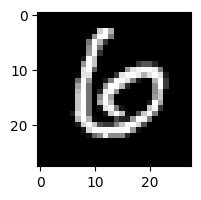

In [296]:
show_prediction(11,X_test, Y_test, W1, b1, W2, b2)
# show_prediction(1,X_test, Y_test, W1, b1, W2, b2)
# show_prediction(2,X_test, Y_test, W1, b1, W2, b2)
# show_prediction(100,X_test, Y_test, W1, b1, W2, b2)
# show_prediction(250,X_test, Y_test, W1, b1, W2, b2)

Prediction:  [9]
Label:  4


<Figure size 640x480 with 0 Axes>

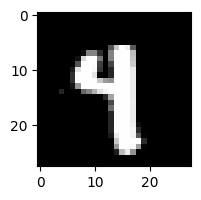

Prediction:  [6]
Label:  8


<Figure size 640x480 with 0 Axes>

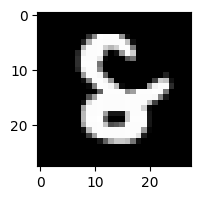

Prediction:  [5]
Label:  9


<Figure size 640x480 with 0 Axes>

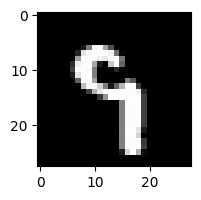

Prediction:  [3]
Label:  5


<Figure size 640x480 with 0 Axes>

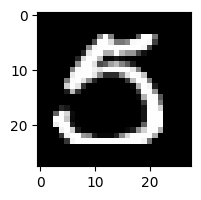

Prediction:  [5]
Label:  9


<Figure size 640x480 with 0 Axes>

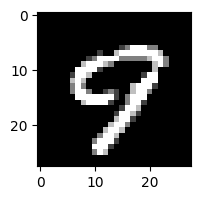

Prediction:  [9]
Label:  3


<Figure size 640x480 with 0 Axes>

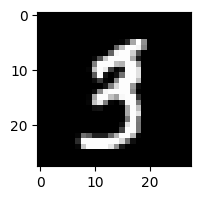

Prediction:  [2]
Label:  7


<Figure size 640x480 with 0 Axes>

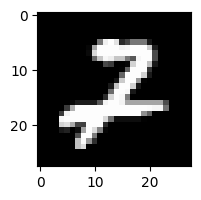

Prediction:  [8]
Label:  2


<Figure size 640x480 with 0 Axes>

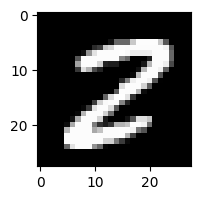

Prediction:  [2]
Label:  7


<Figure size 640x480 with 0 Axes>

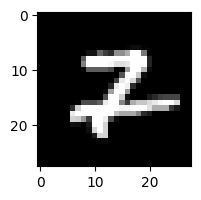

Prediction:  [5]
Label:  0


<Figure size 640x480 with 0 Axes>

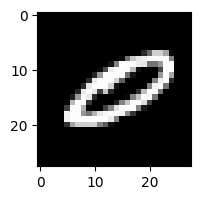

10


In [290]:

show_wrong_predictions((8500,10000),X_test, Y_test, W1, b1, W2, b2,10)

Total incorrect predictions in range:  891
Prediction Accuracy in range:  8.91
Error summary:  {8: 151, 5: 122, 2: 111, 9: 109, 3: 107, 4: 86, 7: 79, 6: 74, 0: 34, 1: 18}


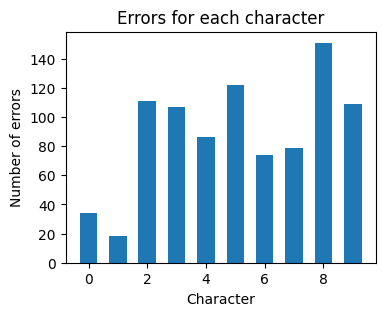

In [279]:
error_details((0,10000),X_test, Y_test, W1, b1, W2, b2)